# Predictive Modelling - Traditional ML methods

This section explores how traditional predictive modelling techniques can help identify and quantify computing skills gaps among young Africans. We use regression-based models to:

- Predict whether a participant has a computing skills gap (binary classification) given different parameters.
- Estimate a continuous skill score that reflects the computing skills score. 

This supports CSA Africa's goals to (1) **evidence the existence of a skill gap**, and (2) **identify the key factors driving it**, enabling more targeted interventions.


## Step 1: Define Target Variables

We will define two types of target variables:
1. A **binary skill gap indicator** (1 = has a skill gap, 0 = no gap), derived from low competence and low programming engagement.
2. A **continuous skill score**, calculated as a composite index based on:
   - Self-rated programming competence
   - Frequency of programming engagement
   - Prior exposure to programming training

This dual target setup allows us to run both classification and regression models.


In [1]:
# Step 1: Import pandas
import pandas as pd

# Step 2: Load the Excel file
file_path = "data/CSA Africa Market Research Questionnaire.xlsx"
df = pd.read_excel(file_path)

# Step 3: Copy the dataset for modelling
df_model = df.copy()

# View unique values for relevant columns to construct skill score
print("Competence:", df_model['How would you describe your programming competence?'].unique())
print("Engagement:", df_model['How often do you engage in computer programming activities?'].unique())
print("Training:", df_model['Have you ever received training in computer programming?'].unique())
print("Training Quality:", df_model['If you have received computer programming education or training, how would you rate the quality of the training received?'].unique())
print("Confidence:", df_model['I am confident in my problem-solving abilities related to computer programming'].unique())



Competence: ['Novice:\xa0has a better understanding of programming principles and can write code with more confidence compared to beginners; they\xa0may still require some assistance and guidance but are more capable of independently tackling coding tasks.'
 'Beginner:\xa0at the very early stages of learning programming, with limited knowledge and experience, able to write simple code but requiring significant guidance.'
 'Not applicable: has no programming experience'
 'Proficient:\xa0demonstrates a high level of programming knowledge and skill, has extensive experience, and the ability to tackle complex programming challenges with high proficiency and independence.\xa0They are skilled at optimizing code performance and they are trusted to make critical decisions and design robust solutions.'
 'Advanced: possesses an in-depth understanding of advanced programming concepts; proficient in multiple programming languages and frameworks; and has a track record of successfully delivering co

### Step 1:1 Encode Self-Rated Competence (Ordinal)
Map textual descriptions of programming competence to ordinal scores.


In [2]:
# Define mapping from textual levels to numeric scale
competence_map = {
    'Not applicable: has no programming experience': 0,
    'Beginner:\xa0at the very early stages of learning programming, with limited knowledge and experience, able to write simple code but requiring significant guidance.': 1,
    'Novice:\xa0has a better understanding of programming principles and can write code with more confidence compared to beginners; they\xa0may still require some assistance and guidance but are more capable of independently tackling coding tasks.': 2,
    'Intermediate: has a solid understanding of programming principles; with moderate experience and skills to work on substantial projects; they may still require occasional guidance or assistance with more advanced topics.': 3,
    'Advanced: possesses an in-depth understanding of advanced programming concepts; proficient in multiple programming languages and frameworks; and has a track record of successfully delivering complex projects.': 4,
    'Proficient:\xa0demonstrates a high level of programming knowledge and skill, has extensive experience, and the ability to tackle complex programming challenges with high proficiency and independence.\xa0They are skilled at optimizing code performance and they are trusted to make critical decisions and design robust solutions.': 5,
    'Expert: displays exceptional expertise in programming and related domains; considered a subject matter expert in specific programming areas; and has extensive experience and contributions to the programming community.': 6
}

# Apply mapping
df_model['competence_score'] = df_model['How would you describe your programming competence?'].map(competence_map)
df_model['competence_score'].value_counts(dropna=False)


competence_score
0    991
1    737
2    376
3    284
5     87
4     32
6     14
Name: count, dtype: int64

### Assessing Programming Competence: Intepretation (evidences the skill-gap)

To begin quantifying the programming skills gap, I analyzed responses to the self-reported programming competence question. Converted the textual responses into an ordinal scale ranging from 0 (No experience) to 6 (Expert).

The distribution of competence scores reveals a strong skew toward the lower end of the spectrum:

- A significant portion of respondents (over 80%) fall into the "No experience" or "Beginner" categories.
- Only a very small fraction (<5%) report being advanced, proficient, or expert.

This strongly evidences the existence of a widespread computing skills gap in the population targeted by CSA Africa. It aligns with the organization’s hypothesis that many young Africans face barriers to acquiring core programming abilities.


### Step 1:2 Encoding Programming Engagement

To further characterize the skill gap, I analyze the frequency with which respondents engage in programming activities. Frequent engagement often correlates with higher skill development and sustained interest.

The engagement responses are categorical and ordinal in nature, ranging from "Rarely or never" to "Daily". We'll encode these responses into a numeric scale to reflect increasing levels of engagement.

**Encoding scheme:**
- "Rarely or never" → 0
- "Occasionally" → 1
- "Once a week" → 2
- "Several times a week" → 3
- "Daily" → 4


In [3]:
# Encoding engagement frequency
engagement_map = {
    'Rarely or never': 0,
    'Occasionally': 1,
    'Once a week': 2,
    'Several times a week': 3,
    'Daily': 4
}

df_model['engagement_score'] = df_model['How often do you engage in computer programming activities?'].map(engagement_map)

# Display distribution
df_model['engagement_score'].value_counts().sort_index()


engagement_score
0    1015
1     525
2     258
3     423
4     300
Name: count, dtype: int64

### Programming Engagement Score Intepretation

Over 40% of respondents (1,015) rarely or never engage in programming, while only 12% (300) report daily engagement. This disparity highlights limited hands-on experience across the majority—an important indicator of the computing skills gap.


### Step 1:3 - Training Exposure Encoding

To capture a participant's training exposure level, process the column:
**"Have you ever received training in computer programming?"**

This column contains combinations of training types (e.g., bootcamps, self-study, formal courses), concatenated with semicolons.

To quantify learners' exposure to programming training, I assign a score based on how many distinct types of training they report. Each unique "Yes" option adds +1 to their score. If the response contains "No" (indicating no prior exposure), I override all "Yes" entries and assign a score of 0.
.


For instance:
- No training = 0
- One training type = 1
- Two types = 2
- ... and so on

This approach allows to quantify training exposure intensity as an ordinal score.


In [4]:
# List of valid training options (excluding 'No')
yes_options = [
    "Yes, I have engaged in self-study or online programming tutorials",
    "Yes, I have taken formal computer programming courses (e.g., as part of my University degree)",
    "Yes, I have participated in coding workshops or boot camps (Free or Scholarship)",
    "Yes, I have participated in coding workshops or boot camps (Paid)",
    "Yes, I have done programming as part of my academic studies (e.g., assignments, projects)",
    "Yes, I have worked on personal programming projects"
]

no_option = "No, I have not had any previous exposure to computer programming"

def compute_training_score_fixed(response):
    if pd.isnull(response):
        return np.nan
    parts = [x.strip() for x in response.split(";") if x.strip()]
    
    # Check for "No" — if present, score is 0
    if any(no_option in part for part in parts):
        return 0

    # Count how many valid "Yes" options are matched
    return sum(1 for opt in yes_options if any(opt in part for part in parts))

# Apply
df_model['training_score'] = df_model['Have you ever received training in computer programming?'].apply(compute_training_score_fixed)

# Check distribution
df_model['training_score'].value_counts().sort_index()


training_score
0    1006
1     811
2     316
3     180
4      99
5      60
6      49
Name: count, dtype: int64

#### Step 1:4 - Encoding Training Quality

I now process the training quality scores provided by respondents who had programming training. This variable is already on an ordinal scale (from 0 to 10), where higher values represent better quality training.

Since the responses are numerical, I retain the scale as-is and treat missing values (from respondents with no training) as `NaN` for now. These will be handled during modeling, or optionally imputed later if needed.



In [5]:
# Check the distribution first
df_model['If you have received computer programming education or training, how would you rate the quality of the training received?'].value_counts(dropna=False)


If you have received computer programming education or training, how would you rate the quality of the training received?
NaN     662
0.0     315
5.0     288
8.0     223
7.0     198
4.0     190
6.0     168
3.0     141
10.0    137
9.0      85
2.0      72
1.0      42
Name: count, dtype: int64

In [6]:
# Rename column for ease of access
df_model.rename(columns={
    'If you have received computer programming education or training, how would you rate the quality of the training received?': 'training_quality_score'
}, inplace=True)

# Check counts after renaming
df_model['training_quality_score'].value_counts(dropna=False).sort_index()


training_quality_score
0.0     315
1.0      42
2.0      72
3.0     141
4.0     190
5.0     288
6.0     168
7.0     198
8.0     223
9.0      85
10.0    137
NaN     662
Name: count, dtype: int64

### Training Quality Intepretation

I processed the self-reported quality of programming training received and renamed the column for clarity. The scores range from 0 (poor quality) to 10 (excellent quality). The distribution shows a broad spread of responses, with:

- **315 respondents** rating their training quality as 0,  
- **137 respondents** giving the highest score of 10,  
- and **662 missing values**, which likely correspond to individuals who did not receive any programming training.

This feature provides a useful measure of the **perceived effectiveness** of prior training. I will include it in the composite skill score as an indicator of **training quality**, contributing to a more nuanced understanding of learners’ programming proficiency.


### Step 1:5 Encoding Confidence in Problem-Solving Abilities

I extract a numeric score from participants' self-reported confidence in their problem-solving abilities related to programming. This variable is ordinal, ranging from *"Strongly Disagree"* to *"Strongly Agree"*. To enable modelling, I convert these responses into a scale from 0 to 5, where higher scores reflect greater confidence. For modelling purposes, I assign scores as follows:

- **Strongly Disagree** → 1  
- **Disagree** → 2  
- **Neutral** → 3  
- **Agree** → 4  
- **Strongly Agree** → 5  
- **Not Applicable** → 0 (interpreted as low confidence or unengaged)

This approach maintains consistency with other ordinal encodings and ensures "Not Applicable" does not get dropped from analysis.

In [7]:
import numpy as np

# View unique values for confidence
print(df_model['I am confident in my problem-solving abilities related to computer programming'].unique())

# Map responses to ordinal scale (0 for Not Applicable)
confidence_mapping = {
    "Not Applicable": 0,
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5
}

# Apply mapping
df_model["confidence_score"] = df_model[
    "I am confident in my problem-solving abilities related to computer programming"
].map(confidence_mapping)

# Check value counts
print(df_model["confidence_score"].value_counts())



['Strongly Agree' 'Neutral' 'Agree' 'Not Applicable' 'Strongly Disagree'
 'Disagree']
confidence_score
4    556
3    521
5    504
0    390
2    372
1    178
Name: count, dtype: int64


### Step 1:6 Constructing comosite score
To quantify learners' programming proficiency in a single measure, I construct a composite skill score using five variables:

- Programming competence (`competence_score`)
- Programming engagement frequency (`engagement_score`)
- Training breadth (`training_score`)
- Quality of training received (`training_quality_score`)
- Confidence in problem-solving (`confidence_score`)

These components reflect different dimensions of skill acquisition. I calculate the composite score as a simple average of the available (non-null) scores. This ensures that missing values in one area do not completely exclude the respondent from analysis, while still maintaining interpretability.




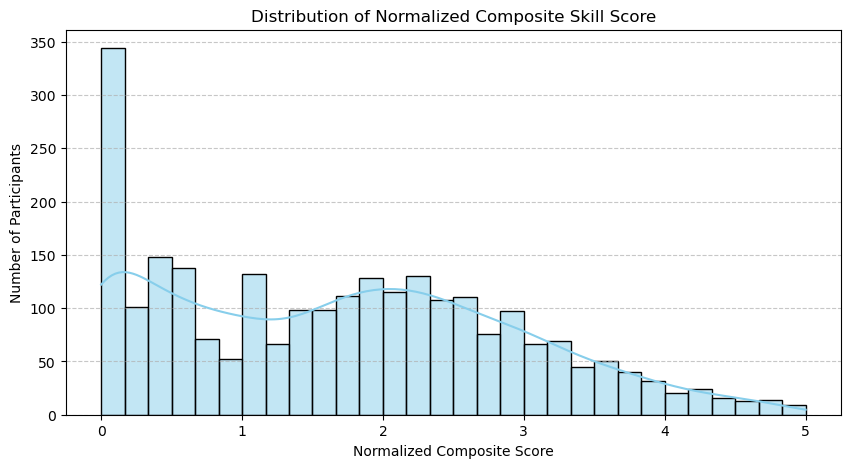

In [10]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to normalize
skill_cols = ['competence_score', 'engagement_score', 'training_score', 'training_quality_score', 'confidence_score']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax scaling
df_model[[f'{col}_norm' for col in skill_cols]] = scaler.fit_transform(df_model[skill_cols])

# Calculate the normalized composite skill score
df_model['normalized_composite_skill_score'] = df_model[[f'{col}_norm' for col in skill_cols]].sum(axis=1)

# Plot the normalized distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_model['normalized_composite_skill_score'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Normalized Composite Skill Score')
plt.xlabel('Normalized Composite Score')
plt.ylabel('Number of Participants')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Interpretation of the Normalized Composite Skill Score Distribution

The distribution of the normalized composite skill scores shows a strong left skew, with a substantial number of participants concentrated near the lower end of the scale. This suggests that a large proportion of the sample exhibits low programming proficiency based on their combined competence, engagement, training exposure, training quality, and confidence levels. While there is a gradual decline in frequency as the score increases, relatively few individuals attain high normalized scores close to the upper limit. This further evidences the presence of a significant skills gap among the surveyed population.


### Step 3: Selecting Features for Predictive Modelling

Now that I’ve constructed a normalized composite skill score to represent learners’ programming proficiency, I will select a set of meaningful independent variables (features) that are likely to influence this skill score. These features span across socio-demographic, infrastructural, and psychological/mindset, social-cultural dimensions and are aligned with CSA Africa’s goal of identifying causal factors for the digital skills gap.


In [21]:
# Define the list of predictor variables (features)
predictor_features = [
    'Age',
    'Gender',
    'Country of residence',
    'Do you have childcare responsibilities?',
    'Highest educational level (already attained)',
    'Employment status',
    'Do you have access to a computer or laptop at your home or within your community?',
    'Do you have access to good internet to support your learning of programming?',
    'Can you afford the cost of accessing the internet for approximately 15 - 20hrs weekly?',
    'How much electricity access do you have to learn programming per day?',
    'How would you rate the level of support you receive from your parent/guardian/spouse in learning computer programming?',
    'How would you describe your current perception of learning computer programming?',
    'What is the major factor limiting your engagement?',
    'Programming is primarily for individuals with strong mathematical or technical backgrounds',
    'I am aware of the various career opportunities available for individuals with computer programming skills',
    'It is important for me to see more representation of my cultural or societal background in the programming industry',
    'It is important for me to have access to mentors or role models in the field of computer programming',
    'On a scale of 1 to 10, how interested are you in learning computer programming or improving on your skills?',
    'Would you be more motivated to learn computer programming if there were more coding communities or meetups in your area?',
    'What career paths are you interested in pursuing with your computer programming skills?',
    'Which of the following factors most strongly motivates you to learn computer programming?',
    'Which of the following challenges have you faced in learning or improving your computer programming skills?',
    'I have encountered societal beliefs that discourage my pursuit of computer programming',
    'I have faced gender-related barriers or stereotypes that discourage my involvement in programming',
    'My immediate family is supportive of my decision to pursue programming',
    'I have experienced societal pressure to pursue traditional career paths instead of programming',
    'I have faced significant barriers in finding relevant opportunities to apply my programming skills',
    'Have you found online coding platforms or communities specifically tailored to the needs of young Africans?',
    'Online learning platforms tailored to the needs of young Africans will enhance my learning process',
    'Have you faced any English language barrier in learning programming?'
]

# Display the selected features
print(f"Number of selected features: {len(predictor_features)}")
# for feature in predictor_features:
#     print("-", feature)


Number of selected features: 30


## Feature Encoding and Preprocessing - Massaging the data for modelling

Before fitting any predictive models, I need to prepare the selected predictor features by encoding them into numerical form. Since most of the features are categorical or ordinal in nature, I’ll use the following strategies:

- **Binary & Single-Select Categorical Variables:** Encoded using Label Encoding (e.g., "Yes"/"No", "Male"/"Female").
- **Nominal Categorical Variables (multi-class):** One-Hot Encoding is used for features like "Country of Residence" or "Employment Status".
- **Ordinal Variables:** Preserved with meaningful numerical ordering where applicable.
- **Multi-Select Text Fields:** These will be simplified into binary indicators based on presence of selected options.

After this step, the resulting DataFrame will contain only numeric values, ready for regression modeling.


In [22]:
from sklearn.preprocessing import LabelEncoder

# Make a working copy of the dataset
df_encoded = df_model.copy()

# Strip leading/trailing spaces from column names in both the dataframe and feature list
df_encoded.columns = df_encoded.columns.str.strip()
predictor_features = [f.strip() for f in predictor_features]

# Container for final features
final_encoded_df = pd.DataFrame(index=df_encoded.index)

# Feature encoding loop
for feature in predictor_features:
    if feature not in df_encoded.columns:
        print(f"Skipping {feature} - Not found in dataset.")
        continue

    col_data = df_encoded[feature].fillna("Missing")

    unique_vals = col_data.nunique()

    if unique_vals == 2:
        # Binary categorical
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data)
    elif unique_vals <= 10:
        # Ordinal / small nominal
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data)
    elif unique_vals < 100:
        # Nominal with moderate cardinality
        dummies = pd.get_dummies(col_data, prefix=feature, drop_first=True)
        final_encoded_df = pd.concat([final_encoded_df, dummies], axis=1)
    else:
        print(f"Skipping {feature} - Too many unique values ({unique_vals})")

print(f"\nFinal shape of encoded feature set: {final_encoded_df.shape}")


Skipping What is the major factor limiting your engagement? - Too many unique values (1126)
Skipping Which of the following factors most strongly motivates you to learn computer programming? - Too many unique values (151)
Skipping Which of the following challenges have you faced in learning or improving your computer programming skills? - Too many unique values (951)

Final shape of encoded feature set: (2521, 154)


In [19]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Make a copy of the DataFrame to work on
df_encoded = df_model.copy()

# Define predictor features (update if needed)
predictor_features = [
    'Age',
    'Gender',
    'Country of residence',
    'Do you have childcare responsibilities?',
    'Highest educational level (already attained)',
    'Employment status',
    'Do you have access to a computer or laptop at your home or within your community?',
    'Do you have access to good internet to support your learning of programming?',
    'Can you afford the cost of accessing the internet for approximately 15 - 20hrs weekly?',
    'How much electricity access do you have to learn programming per day?',
    'How would you rate the level of support you receive from your parent/guardian/spouse in learning computer programming?',
    'What source of income have you used to support your previous exposure to programming? ',
    'How would you describe your current perception of learning computer programming?',
    'Programming is primarily for individuals with strong mathematical or technical backgrounds',
    'I am aware of the various career opportunities available for individuals with computer programming skills',
    'It is important for me to see more representation of my cultural or societal background in the programming industry',
    'It is important for me to have access to mentors or role models in the field of computer programming',
    'On a scale of 1 to 10, how interested are you in learning computer programming or improving on your skills?',
    'Would you be more motivated to learn computer programming if there were more coding communities or meetups in your area?',
    'What career paths are you interested in pursuing with your computer programming skills?',
    'Which of the following factors most strongly motivates you to learn computer programming? ',
    'Which of the following challenges have you faced in learning or improving your computer programming skills?',
    'I have encountered societal beliefs that discourage my pursuit of computer programming',
    'I have faced gender-related barriers or stereotypes that discourage my involvement in programming',
    'My immediate family is supportive of my decision to pursue programming',
    'I have experienced societal pressure to pursue traditional career paths instead of programming',
    'I have faced significant barriers in finding relevant opportunities to apply my programming skills',
    'Have you found online coding platforms or communities specifically tailored to the needs of young Africans?',
    'Online learning platforms tailored to the needs of young Africans will enhance my learning process',
    'Have you faced any English language barrier in learning programming?'
]

# Track encoded features
final_encoded_df = pd.DataFrame(index=df_encoded.index)

for feature in predictor_features:
    if feature not in df_encoded.columns:
        print(f"Skipping {feature} - Not found in dataset.")
        continue

    # Drop NaNs for encoding purposes
    col_data = df_encoded[feature].fillna("Missing")

    if col_data.nunique() == 2:
        # Binary encoding
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data)
    elif col_data.nunique() <= 10:
        # Ordinal or small nominal variable - Label encode
        le = LabelEncoder()
        final_encoded_df[feature] = le.fit_transform(col_data)
    elif col_data.nunique() > 10 and col_data.nunique() < 100:
        # One-hot encode
        dummies = pd.get_dummies(col_data, prefix=feature, drop_first=True)
        final_encoded_df = pd.concat([final_encoded_df, dummies], axis=1)
    else:
        print(f"Skipping {feature} - Too many unique values ({col_data.nunique()})")

print(f"Final shape of encoded feature set: {final_encoded_df.shape}")


Skipping How much electricity access do you have to learn programming per day? - Not found in dataset.
Skipping What source of income have you used to support your previous exposure to programming?  - Not found in dataset.
Skipping Which of the following factors most strongly motivates you to learn computer programming?  - Too many unique values (151)
Skipping Which of the following challenges have you faced in learning or improving your computer programming skills? - Too many unique values (951)
Final shape of encoded feature set: (2521, 153)


In [23]:
# Merge encoded predictors with the normalized composite skill score
final_df = final_encoded_df.copy()
final_df['normalized_composite_skill_score'] = df_model['normalized_composite_skill_score']

# Drop any rows where the skill score is missing (if any)
final_df = final_df.dropna(subset=['normalized_composite_skill_score'])

# Confirm the final dataset shape and preview
print(f"Final modelling dataset shape: {final_df.shape}")
final_df.head()


Final modelling dataset shape: (2521, 155)


,Age,Gender,Country of residence_Botswana,Country of residence_Central African Republic,Country of residence_Eswatini,Country of residence_Ghana,Country of residence_Kenya,Country of residence_Malawi,Country of residence_Nigeria,Country of residence_Rwanda,...,What career paths are you interested in pursuing with your computer programming skills?_backend developer,I have encountered societal beliefs that discourage my pursuit of computer programming,I have faced gender-related barriers or stereotypes that discourage my involvement in programming,My immediate family is supportive of my decision to pursue programming,I have experienced societal pressure to pursue traditional career paths instead of programming,I have faced significant barriers in finding relevant opportunities to apply my programming skills,Have you found online coding platforms or communities specifically tailored to the needs of young Africans?,Online learning platforms tailored to the needs of young Africans will enhance my learning process,Have you faced any English language barrier in learning programming?,normalized_composite_skill_score
0,1,2,False,False,False,False,False,False,True,False,...,False,0,4,0,4,3,0,4,0,2.000000
1,4,2,False,False,False,True,False,False,False,False,...,False,2,2,2,2,2,0,0,0,1.783333
2,3,1,False,False,False,True,False,False,False,False,...,False,5,5,4,3,2,0,2,0,1.783333
3,4,2,False,False,False,True,False,False,False,False,...,False,0,1,2,0,4,0,4,1,1.000000
4,4,2,False,False,False,True,False,False,False,False,...,False,1,5,2,5,2,0,2,0,0.000000


In [24]:
final_df.head().to_excel("df_sample.xlsx", index=False)

## Linear Regression: Predicting Programming Skill Score

### Objective
In this section, I apply a **traditional linear regression model** to predict the `normalized_composite_skill_score`, which serves as a proxy for programming proficiency among participants. This score was computed by combining multiple indicators of skill acquisition such as self-rated competence, frequency of coding engagement, training exposure, training quality, and confidence.

The goal is to estimate how various socio-demographic, infrastructural, motivational, and perceptual features influence an individual’s overall programming skill level. This aligns directly with CSA Africa’s objective of identifying and addressing the underlying factors contributing to digital skill disparities.

---

###  Why Linear Regression?
Linear regression is a fundamental predictive modeling technique that estimates the **linear relationship** between input variables (predictors) and a continuous outcome (target). It is especially useful for:

- Measuring how much each feature contributes to the predicted skill score.
- Interpreting feature coefficients to assess their relative influence.
- Establishing a baseline for comparison with more complex models (e.g., Bayesian or causal models later on).

---

### Modelling Workflow

Here’s how I approach the modelling process:

1. **Import necessary libraries**: I load tools for regression, evaluation, and data manipulation.
2. **Define predictors and target**: The independent variables (`X`) consist of all encoded participant features. The dependent variable (`y`) is the normalized skill score.
3. **Split the data**: I use an 80/20 split for training and testing to evaluate model performance on unseen data.
4. **Train the model**: I fit a `LinearRegression` model to the training set.
5. **Evaluate performance**: I compute RMSE (root mean square error) and R² (coefficient of determination) to assess prediction accuracy.
6. **Interpret feature importance**: I analyze the learned coefficients to understand which features most strongly predict higher or lower skill levels.

This linear regression model serves as a transparent and interpretable first step in identifying predictors of programming proficiency in the African context.


In [25]:
# For modelling and evaluation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [26]:
# Features are all columns except the target
X = final_df.drop(columns=['normalized_composite_skill_score'])

# Target is the normalized skill score
y = final_df['normalized_composite_skill_score']


In [27]:
# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [28]:
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [29]:
# Predictions
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.8693
R² Score: 0.4866


In [30]:
# Coefficients and feature impact
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

feature_importance.head(10)  # Show top 10 positive predictors


,Feature,Coefficient
10,Country of residence_South Sudan,1.879615
113,What career paths are you interested in pursui...,1.708465
64,How would you describe your current perception...,1.633643
59,How would you describe your current perception...,1.247094
83,How would you describe your current perception...,0.972889
32,Highest educational level (already attained)_U...,0.925938
11,Country of residence_Tanzania,0.871346
7,Country of residence_Malawi,0.793241
114,What career paths are you interested in pursui...,0.792648
4,Country of residence_Eswatini,0.772809


### Linear Regression Model Summary

The linear regression model provided an interpretable baseline for predicting the composite programming skill score based on socio-demographic, infrastructural, and psychological factors.

**Model Performance:**
- **RMSE (Root Mean Squared Error):** ~0.87 — This indicates a moderate average prediction error given the normalized skill score range (0–5).
- **R² Score:** 0.49 — The model explains approximately **49%** of the variance in skill scores. While this shows the model captures some meaningful relationships, it also suggests that over half the variation remains unexplained.

**Top Predictors Identified:**
The features with the strongest positive influence on programming skill scores include:
- Residing in **South Sudan**, **Tanzania**, **Malawi**, or **Eswatini**.
- Expressing specific **career aspirations** in programming (e.g., backend development).
- Positive **psychological perceptions** of programming.
- Achieving certain levels of **education**.

These results provide useful directional insights into which contextual and psychological factors may be linked with higher skills attainment.

**Limitations:**
However, linear models assume simple additive relationships and may not fully capture:
- **Non-linear interactions** (e.g., between infrastructure and mindset),
- **Feature interactions** (e.g., education * electricity access),
- **Complex dependencies** or latent structure in the data.

---

### Next Steps

To improve predictive performance and uncover deeper patterns, I will now explore **non-linear machine learning models**, such as:
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

These models are better suited to handle complex, high-dimensional data and can often achieve higher accuracy without requiring extensive feature engineering.


### Random Forest Regressor

I now train a Random Forest regression model to improve upon the linear regression baseline. Random Forest is a powerful ensemble learning method that handles non-linear relationships and interactions between features well, which are likely present in this dataset. It also provides built-in feature importance, which is useful for ranking predictors based on their impact on the normalized composite skill score.


RMSE: 0.2839
R² Score: 0.9472


C:\Users\grace\AppData\Local\Temp\ipykernel_23448\626201948.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


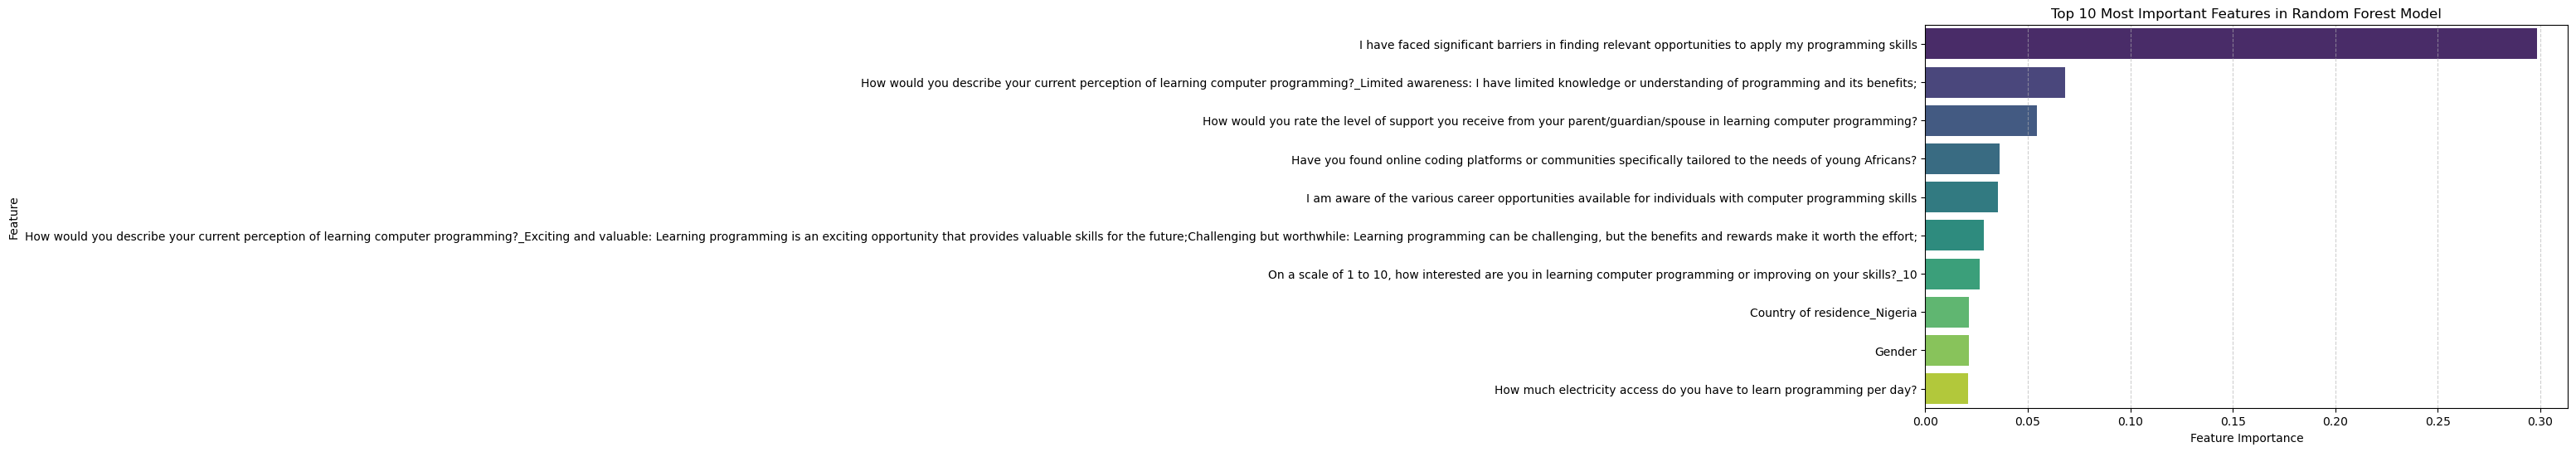

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Predict and evaluate
y_pred = rf.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature',  hue='Feature',  palette='viridis',  dodge=False,
    legend=False)
plt.title('Top 10 Most Important Features in Random Forest Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Save top 20 to Excel (optional)
feature_importances.head(20).to_excel("random_forest_feature_importance.xlsx", index=False)


### Random Forest Regression: Model Performance and Key Feature Insights

To improve on the limitations of linear regression, I applied a Random Forest regression model to predict the normalized composite skill score. This model is especially useful for capturing nonlinear relationships and handling complex interactions among features.

The model achieved a **Root Mean Squared Error (RMSE) of 0.2839**, which indicates low average prediction error on the normalized scale. More impressively, it attained an **R² score of 0.947**, meaning it explains approximately **95% of the variance** in the outcome variable. This reflects a substantial improvement in performance compared to linear models.

The plot above shows the **Top 10 most influential features** in predicting computing skill proficiency according to the Random Forest model. These include:

- **Barriers to applying skills** (e.g., lack of opportunities),
- **Learners' perceptions and awareness** of programming,
- **Support from family/guardians/spouse**,
- **Access to contextual learning platforms**,
- **Knowledge of computing career opportunities**,
- **Level of interest and motivation**,
- **Electricity access, gender, and geographic location** (e.g., being based in Nigeria).

This combination of infrastructural, psychological, and socio-demographic features strongly predicts skill development outcomes, and the results align with CSA Africa’s goal of uncovering the key causal or structural barriers.

Given the strong performance and deeper insights from this model, Random Forests provide a solid baseline before advancing to **Bayesian and causal modelling**, which will further allow me to capture uncertainty, perform probabilistic reasoning, and simulate cause-effect relationships.


### XGBoost Regression: Modelling and Motivation
To further enhance predictive performance and model interpretability, I now apply XGBoost (Extreme Gradient Boosting) a powerful tree-based ensemble technique known for its robustness, speed, and superior handling of complex patterns in structured data. XGBoost often outperforms traditional machine learning models by reducing both bias and variance through iterative boosting.

Given its effectiveness in feature selection, regularization, and handling missing values, XGBoost is a valuable addition to this project. It will allow me to compare performance against Random Forests and potentially gain sharper insights into which variables most strongly influence computing skill levels.

In [35]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 599.9 kB/s eta 0:04:10
   ---------------------------------------- 0.8/150.0 MB 599.2 kB/s eta 0:04:09
   ---------------------------------------- 0.8/150.0 MB 599.2 kB/s eta 0:04:09
   ---------------------------------------- 0.8/150.0 MB 599.2 kB/s eta 0:04:09
   ---------------------------------------- 1.0/150.0 MB 606.3 kB/s eta 0:04:06
   ---------------------------------------- 1.0/150.0 MB 606.3 kB/s eta 0:04:06
   ---------------------------------------- 1.3/150.0 MB 604.7 kB/s eta 0:04:06
   ---------------------------------------- 1.3/150.0 MB 604.7 kB/s eta 0:04:06
   --

XGBoost RMSE: 0.2804
XGBoost R² Score: 0.9485


C:\Users\grace\AppData\Local\Temp\ipykernel_23448\2999645383.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_imp_df, x='Importance', y='Feature', palette='crest')
C:\Users\grace\AppData\Local\Temp\ipykernel_23448\2999645383.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


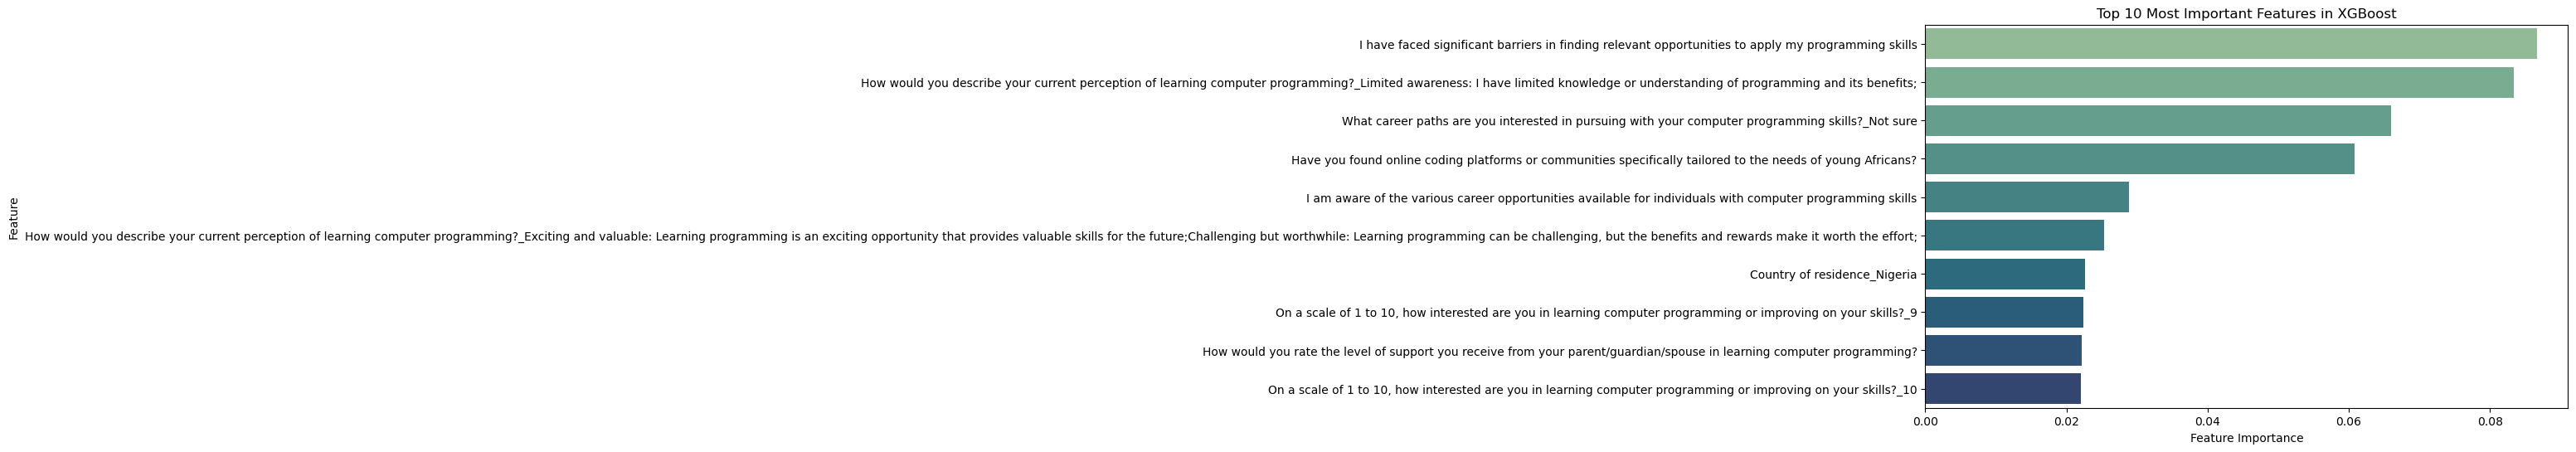

In [36]:
import xgboost as xgb

# Prepare data
X = final_df.drop('normalized_composite_skill_score', axis=1)
y = final_df['normalized_composite_skill_score']

# Initialize and fit the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X, y)

# Predict
y_pred_xgb = xgb_model.predict(X)

# Evaluate performance
rmse_xgb = np.sqrt(mean_squared_error(y, y_pred_xgb))
r2_xgb = r2_score(y, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")

# Plot top 10 feature importances
xgb_importances = xgb_model.feature_importances_
xgb_feat_names = X.columns
xgb_feat_imp_df = pd.DataFrame({'Feature': xgb_feat_names, 'Importance': xgb_importances})
xgb_feat_imp_df = xgb_feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feat_imp_df, x='Importance', y='Feature', palette='crest')
plt.title('Top 10 Most Important Features in XGBoost')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### XGBoost Regression Results: Interpretation and Insights

The XGBoost regression model performed well on the prediction task, achieving an **RMSE of 0.2804** and an **R² score of 0.9485**. This indicates a very high level of predictive accuracy, with the model explaining about 95% of the variance in the normalized composite skill score.

The **top predictors** identified by the XGBoost model are largely **similar to those found in the Random Forest model**. These include:
- Facing significant barriers in applying programming skills
- Limited awareness or understanding of programming
- Uncertainty about career paths
- Access to support systems and learning communities
- Country of residence and learner interest levels

This consistency across models strengthens the reliability of these variables as important drivers of skill development. It also confirms that **structural, psychological, and infrastructural factors** are key to understanding the programming skill gap.

With these findings in hand, the next step is to move beyond prediction and explore **Bayesian modelling and causal inference**, to better understand uncertainty and causal relationships in the data.


# Bayesian Modelling